# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

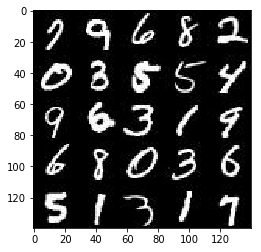

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

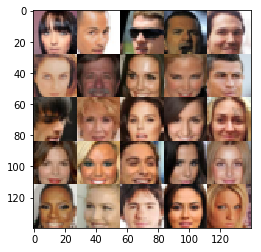

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    inputs_real = tf.placeholder(tf.float32, shape=(None, image_width, image_height, image_channels), name='input_real') 
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')
    
    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 28x28x3
        x1 = tf.layers.conv2d(images, 128, 5, strides=2, padding='same')
        relu1 = tf.maximum(0.2 * x1, x1)
        # 14x14x128
        
        
        x2 = tf.layers.conv2d(relu1, 256, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(0.2 * bn2, bn2)
        # 7x7x256
        
        x3 = tf.layers.conv2d(relu2, 512, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(0.2 * bn3, bn3)
        # 4x4x512
        
        # Flatten it
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    with tf.variable_scope('generator', reuse=not is_train):
        # First fully connected layer
        x1 = tf.layers.dense(z, 7*7*512)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(0.2 * x1, x1)
        # 7x7x512 now
        
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(0.2 * x2, x2)
        # 14x14x256 now
        
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(0.2 * x3, x3)
        # 28x28x128 now
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=1, padding='same')
        # 28x28x3 now
        
        out = tf.tanh(logits)
        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real) * 0.9))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    vars = tf.trainable_variables()
    d_vars = [var for var in vars if var.name.startswith('discriminator')]
    g_vars = [var for var in vars if var.name.startswith('generator')]
    all_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)

    g_update_ops = [var for var in all_update_ops if var.name.startswith('generator')]
    d_update_ops = [var for var in all_update_ops if var.name.startswith('discriminator')]

    with tf.control_dependencies(d_update_ops):
        d_train = tf.train.AdamOptimizer(learning_rate, beta1 = beta1).minimize(d_loss, var_list = d_vars)

    with tf.control_dependencies(g_update_ops):
        g_train = tf.train.AdamOptimizer(learning_rate, beta1 = beta1).minimize(g_loss, var_list = g_vars)
    
    return d_train, g_train


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    input_real, input_z, _ = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1
                batch_images = batch_images * 2
                
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z})
                
                if steps % 10 == 0:
                    # After 10 steps, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if steps % 100 == 0:
                    # After 100 steps, print sample images
                    show_generator_output(sess, 4, input_z, data_shape[3], data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.4970... Generator Loss: 2.6324
Epoch 1/2... Discriminator Loss: 0.5267... Generator Loss: 14.9615
Epoch 1/2... Discriminator Loss: 0.3540... Generator Loss: 6.3537
Epoch 1/2... Discriminator Loss: 0.5774... Generator Loss: 6.9606
Epoch 1/2... Discriminator Loss: 0.3704... Generator Loss: 4.4953
Epoch 1/2... Discriminator Loss: 0.9063... Generator Loss: 2.0431
Epoch 1/2... Discriminator Loss: 0.8607... Generator Loss: 1.5706
Epoch 1/2... Discriminator Loss: 0.9349... Generator Loss: 8.2371
Epoch 1/2... Discriminator Loss: 0.4688... Generator Loss: 3.2083
Epoch 1/2... Discriminator Loss: 0.6616... Generator Loss: 2.2445


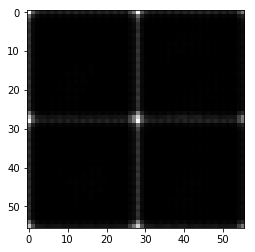

Epoch 1/2... Discriminator Loss: 0.9823... Generator Loss: 1.3586
Epoch 1/2... Discriminator Loss: 1.3376... Generator Loss: 2.5650
Epoch 1/2... Discriminator Loss: 1.0550... Generator Loss: 1.2622
Epoch 1/2... Discriminator Loss: 1.3091... Generator Loss: 0.6682
Epoch 1/2... Discriminator Loss: 1.0928... Generator Loss: 1.8363
Epoch 1/2... Discriminator Loss: 1.2329... Generator Loss: 0.7160
Epoch 1/2... Discriminator Loss: 1.1025... Generator Loss: 1.1485
Epoch 1/2... Discriminator Loss: 1.2384... Generator Loss: 0.8813
Epoch 1/2... Discriminator Loss: 0.9923... Generator Loss: 1.3590
Epoch 1/2... Discriminator Loss: 1.1525... Generator Loss: 1.7874


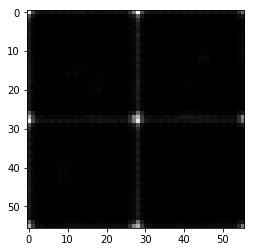

Epoch 1/2... Discriminator Loss: 1.1245... Generator Loss: 1.3408
Epoch 1/2... Discriminator Loss: 1.2386... Generator Loss: 0.8028
Epoch 1/2... Discriminator Loss: 1.1278... Generator Loss: 1.4953
Epoch 1/2... Discriminator Loss: 1.2659... Generator Loss: 2.3664
Epoch 1/2... Discriminator Loss: 1.0742... Generator Loss: 1.2730
Epoch 1/2... Discriminator Loss: 0.9984... Generator Loss: 1.3897
Epoch 1/2... Discriminator Loss: 0.9844... Generator Loss: 1.1611
Epoch 1/2... Discriminator Loss: 0.9276... Generator Loss: 1.1511
Epoch 1/2... Discriminator Loss: 1.0112... Generator Loss: 1.5776
Epoch 1/2... Discriminator Loss: 1.0268... Generator Loss: 1.6055


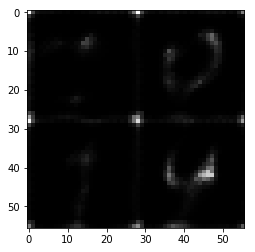

Epoch 1/2... Discriminator Loss: 1.0761... Generator Loss: 1.0500
Epoch 1/2... Discriminator Loss: 1.3839... Generator Loss: 2.1746
Epoch 1/2... Discriminator Loss: 1.0333... Generator Loss: 1.2034
Epoch 1/2... Discriminator Loss: 1.2765... Generator Loss: 0.6602
Epoch 1/2... Discriminator Loss: 1.0614... Generator Loss: 1.1216
Epoch 1/2... Discriminator Loss: 1.3282... Generator Loss: 0.7233
Epoch 1/2... Discriminator Loss: 1.2715... Generator Loss: 0.6622
Epoch 1/2... Discriminator Loss: 1.1821... Generator Loss: 1.7167
Epoch 1/2... Discriminator Loss: 1.1013... Generator Loss: 1.7658
Epoch 1/2... Discriminator Loss: 1.0999... Generator Loss: 1.0093


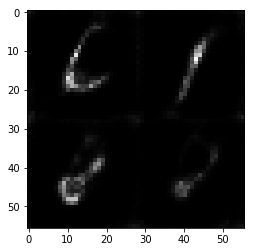

Epoch 1/2... Discriminator Loss: 1.0602... Generator Loss: 1.2026
Epoch 1/2... Discriminator Loss: 1.2505... Generator Loss: 1.8754
Epoch 1/2... Discriminator Loss: 1.0658... Generator Loss: 1.8704
Epoch 1/2... Discriminator Loss: 1.0919... Generator Loss: 0.8444
Epoch 1/2... Discriminator Loss: 1.1323... Generator Loss: 1.4977
Epoch 1/2... Discriminator Loss: 1.3312... Generator Loss: 0.6053
Epoch 1/2... Discriminator Loss: 1.0667... Generator Loss: 0.9873
Epoch 1/2... Discriminator Loss: 1.0110... Generator Loss: 1.2175
Epoch 1/2... Discriminator Loss: 1.1964... Generator Loss: 0.7717
Epoch 1/2... Discriminator Loss: 1.0719... Generator Loss: 0.9484


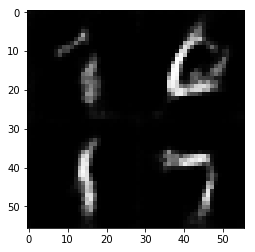

Epoch 1/2... Discriminator Loss: 0.9708... Generator Loss: 1.1216
Epoch 1/2... Discriminator Loss: 1.1809... Generator Loss: 2.0527
Epoch 1/2... Discriminator Loss: 1.0609... Generator Loss: 1.0934
Epoch 1/2... Discriminator Loss: 1.1994... Generator Loss: 1.7562
Epoch 1/2... Discriminator Loss: 1.0658... Generator Loss: 0.9905
Epoch 1/2... Discriminator Loss: 1.1012... Generator Loss: 1.3644
Epoch 1/2... Discriminator Loss: 1.0924... Generator Loss: 0.8950
Epoch 1/2... Discriminator Loss: 1.0981... Generator Loss: 0.9920
Epoch 1/2... Discriminator Loss: 1.0825... Generator Loss: 0.9972
Epoch 1/2... Discriminator Loss: 1.1503... Generator Loss: 1.4871


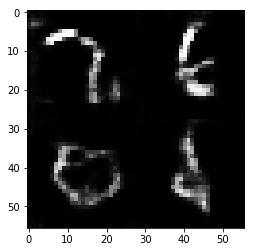

Epoch 2/2... Discriminator Loss: 1.2908... Generator Loss: 0.6125
Epoch 2/2... Discriminator Loss: 1.0595... Generator Loss: 1.1222
Epoch 2/2... Discriminator Loss: 0.9979... Generator Loss: 1.1744
Epoch 2/2... Discriminator Loss: 0.9822... Generator Loss: 1.5577
Epoch 2/2... Discriminator Loss: 1.2350... Generator Loss: 1.8200
Epoch 2/2... Discriminator Loss: 1.1129... Generator Loss: 1.0862
Epoch 2/2... Discriminator Loss: 1.2303... Generator Loss: 0.6405
Epoch 2/2... Discriminator Loss: 0.9249... Generator Loss: 1.6891
Epoch 2/2... Discriminator Loss: 1.3851... Generator Loss: 0.5364
Epoch 2/2... Discriminator Loss: 1.1814... Generator Loss: 0.7804


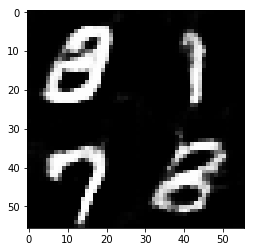

Epoch 2/2... Discriminator Loss: 1.1565... Generator Loss: 1.8393
Epoch 2/2... Discriminator Loss: 1.0333... Generator Loss: 0.8776
Epoch 2/2... Discriminator Loss: 0.9116... Generator Loss: 1.3877
Epoch 2/2... Discriminator Loss: 1.1192... Generator Loss: 0.8429
Epoch 2/2... Discriminator Loss: 0.9206... Generator Loss: 1.6160
Epoch 2/2... Discriminator Loss: 0.9319... Generator Loss: 1.7685
Epoch 2/2... Discriminator Loss: 1.0031... Generator Loss: 0.9418
Epoch 2/2... Discriminator Loss: 1.3398... Generator Loss: 0.5694
Epoch 2/2... Discriminator Loss: 1.0256... Generator Loss: 1.2116
Epoch 2/2... Discriminator Loss: 0.8951... Generator Loss: 1.2226


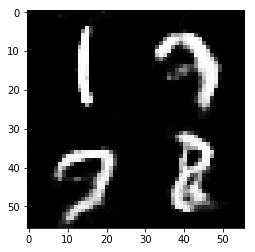

Epoch 2/2... Discriminator Loss: 0.9693... Generator Loss: 1.3680
Epoch 2/2... Discriminator Loss: 0.7983... Generator Loss: 1.3992
Epoch 2/2... Discriminator Loss: 1.2952... Generator Loss: 2.5527
Epoch 2/2... Discriminator Loss: 0.9473... Generator Loss: 1.2280
Epoch 2/2... Discriminator Loss: 1.2155... Generator Loss: 0.6341
Epoch 2/2... Discriminator Loss: 0.8765... Generator Loss: 1.1966
Epoch 2/2... Discriminator Loss: 0.8811... Generator Loss: 1.2392
Epoch 2/2... Discriminator Loss: 1.2497... Generator Loss: 0.8070
Epoch 2/2... Discriminator Loss: 0.9752... Generator Loss: 0.9376
Epoch 2/2... Discriminator Loss: 0.9454... Generator Loss: 1.0847


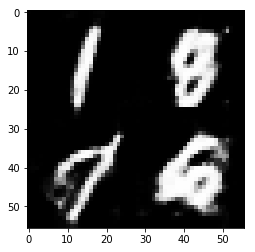

Epoch 2/2... Discriminator Loss: 0.9270... Generator Loss: 1.4338
Epoch 2/2... Discriminator Loss: 1.4582... Generator Loss: 0.5656
Epoch 2/2... Discriminator Loss: 1.0033... Generator Loss: 0.9611
Epoch 2/2... Discriminator Loss: 0.9233... Generator Loss: 1.4408
Epoch 2/2... Discriminator Loss: 0.9285... Generator Loss: 1.3367
Epoch 2/2... Discriminator Loss: 0.9346... Generator Loss: 1.4068
Epoch 2/2... Discriminator Loss: 1.2236... Generator Loss: 0.6658
Epoch 2/2... Discriminator Loss: 0.7867... Generator Loss: 1.5111
Epoch 2/2... Discriminator Loss: 1.3071... Generator Loss: 2.4266
Epoch 2/2... Discriminator Loss: 1.0165... Generator Loss: 0.9124


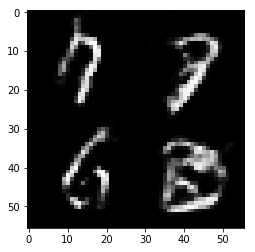

Epoch 2/2... Discriminator Loss: 1.2163... Generator Loss: 0.6237
Epoch 2/2... Discriminator Loss: 1.1539... Generator Loss: 0.6974
Epoch 2/2... Discriminator Loss: 0.8645... Generator Loss: 1.4004
Epoch 2/2... Discriminator Loss: 1.5848... Generator Loss: 0.4222
Epoch 2/2... Discriminator Loss: 1.0060... Generator Loss: 1.2221
Epoch 2/2... Discriminator Loss: 0.8997... Generator Loss: 1.4592
Epoch 2/2... Discriminator Loss: 1.0511... Generator Loss: 0.9105
Epoch 2/2... Discriminator Loss: 0.9699... Generator Loss: 1.1642
Epoch 2/2... Discriminator Loss: 0.9434... Generator Loss: 1.4545
Epoch 2/2... Discriminator Loss: 1.0223... Generator Loss: 0.8347


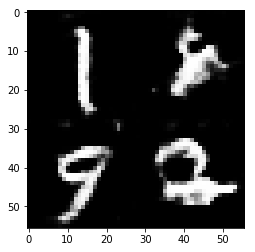

Epoch 2/2... Discriminator Loss: 0.9926... Generator Loss: 1.5283
Epoch 2/2... Discriminator Loss: 0.9189... Generator Loss: 1.5067
Epoch 2/2... Discriminator Loss: 1.0854... Generator Loss: 0.7854
Epoch 2/2... Discriminator Loss: 1.0275... Generator Loss: 0.9074
Epoch 2/2... Discriminator Loss: 0.9391... Generator Loss: 1.0273
Epoch 2/2... Discriminator Loss: 1.0806... Generator Loss: 1.0760
Epoch 2/2... Discriminator Loss: 0.9804... Generator Loss: 1.0061
Epoch 2/2... Discriminator Loss: 0.8065... Generator Loss: 1.6655
Epoch 2/2... Discriminator Loss: 0.9488... Generator Loss: 1.4803
Epoch 2/2... Discriminator Loss: 1.1815... Generator Loss: 0.6836


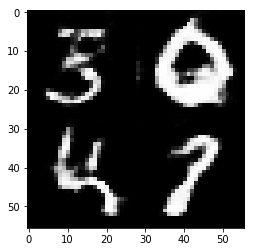

In [12]:
batch_size = 100
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.4375... Generator Loss: 5.5460
Epoch 1/1... Discriminator Loss: 0.5790... Generator Loss: 9.1636
Epoch 1/1... Discriminator Loss: 0.4535... Generator Loss: 10.5384
Epoch 1/1... Discriminator Loss: 4.4192... Generator Loss: 11.5387
Epoch 1/1... Discriminator Loss: 0.7316... Generator Loss: 1.7908
Epoch 1/1... Discriminator Loss: 0.5874... Generator Loss: 2.3694
Epoch 1/1... Discriminator Loss: 0.6179... Generator Loss: 2.6769
Epoch 1/1... Discriminator Loss: 0.4422... Generator Loss: 3.9370
Epoch 1/1... Discriminator Loss: 0.6423... Generator Loss: 1.9450
Epoch 1/1... Discriminator Loss: 0.4802... Generator Loss: 3.7882


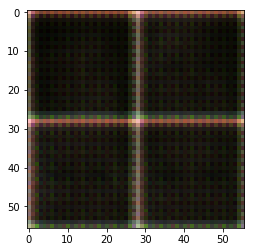

Epoch 1/1... Discriminator Loss: 0.7491... Generator Loss: 1.3621
Epoch 1/1... Discriminator Loss: 0.6252... Generator Loss: 1.7887
Epoch 1/1... Discriminator Loss: 0.6494... Generator Loss: 1.8099
Epoch 1/1... Discriminator Loss: 0.5772... Generator Loss: 2.1521
Epoch 1/1... Discriminator Loss: 0.4444... Generator Loss: 3.7948
Epoch 1/1... Discriminator Loss: 0.4715... Generator Loss: 2.8589
Epoch 1/1... Discriminator Loss: 1.2339... Generator Loss: 0.6453
Epoch 1/1... Discriminator Loss: 1.1568... Generator Loss: 0.7271
Epoch 1/1... Discriminator Loss: 1.8046... Generator Loss: 0.8140
Epoch 1/1... Discriminator Loss: 0.9608... Generator Loss: 1.0517


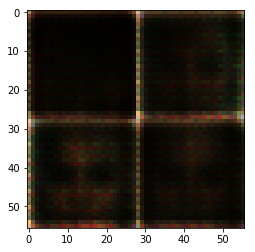

Epoch 1/1... Discriminator Loss: 0.8389... Generator Loss: 2.3275
Epoch 1/1... Discriminator Loss: 0.6939... Generator Loss: 3.3454
Epoch 1/1... Discriminator Loss: 1.1200... Generator Loss: 0.7992
Epoch 1/1... Discriminator Loss: 0.9485... Generator Loss: 1.3772
Epoch 1/1... Discriminator Loss: 0.9848... Generator Loss: 1.1821
Epoch 1/1... Discriminator Loss: 1.4442... Generator Loss: 0.5192
Epoch 1/1... Discriminator Loss: 0.9228... Generator Loss: 1.1272
Epoch 1/1... Discriminator Loss: 0.9034... Generator Loss: 1.0404
Epoch 1/1... Discriminator Loss: 1.1385... Generator Loss: 0.7542
Epoch 1/1... Discriminator Loss: 1.7061... Generator Loss: 0.3629


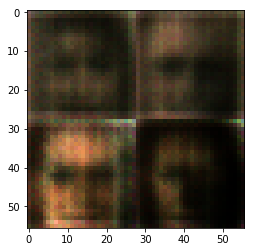

Epoch 1/1... Discriminator Loss: 0.7847... Generator Loss: 1.2571
Epoch 1/1... Discriminator Loss: 0.7408... Generator Loss: 2.1728
Epoch 1/1... Discriminator Loss: 0.7416... Generator Loss: 2.2934
Epoch 1/1... Discriminator Loss: 1.1399... Generator Loss: 1.6431
Epoch 1/1... Discriminator Loss: 0.7030... Generator Loss: 1.8157
Epoch 1/1... Discriminator Loss: 1.5256... Generator Loss: 0.4375
Epoch 1/1... Discriminator Loss: 0.5434... Generator Loss: 4.3405
Epoch 1/1... Discriminator Loss: 0.5666... Generator Loss: 1.8752
Epoch 1/1... Discriminator Loss: 0.5094... Generator Loss: 3.3310
Epoch 1/1... Discriminator Loss: 0.6229... Generator Loss: 1.6629


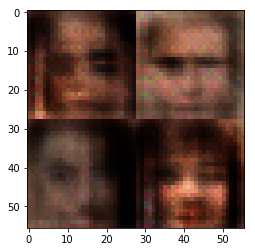

Epoch 1/1... Discriminator Loss: 1.3004... Generator Loss: 0.8954
Epoch 1/1... Discriminator Loss: 0.6267... Generator Loss: 3.1714
Epoch 1/1... Discriminator Loss: 0.3931... Generator Loss: 3.4527
Epoch 1/1... Discriminator Loss: 0.5569... Generator Loss: 5.6858
Epoch 1/1... Discriminator Loss: 0.6011... Generator Loss: 2.5479
Epoch 1/1... Discriminator Loss: 0.5404... Generator Loss: 2.4241
Epoch 1/1... Discriminator Loss: 1.5654... Generator Loss: 0.3916
Epoch 1/1... Discriminator Loss: 0.7607... Generator Loss: 1.4629
Epoch 1/1... Discriminator Loss: 0.6649... Generator Loss: 2.0620
Epoch 1/1... Discriminator Loss: 0.4031... Generator Loss: 3.7961


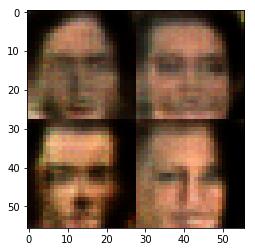

Epoch 1/1... Discriminator Loss: 0.6020... Generator Loss: 2.3359
Epoch 1/1... Discriminator Loss: 1.0410... Generator Loss: 0.9614
Epoch 1/1... Discriminator Loss: 1.2626... Generator Loss: 0.6238
Epoch 1/1... Discriminator Loss: 0.7784... Generator Loss: 3.3407
Epoch 1/1... Discriminator Loss: 0.4678... Generator Loss: 2.9258
Epoch 1/1... Discriminator Loss: 0.6138... Generator Loss: 1.7179
Epoch 1/1... Discriminator Loss: 0.9591... Generator Loss: 0.9842
Epoch 1/1... Discriminator Loss: 0.4517... Generator Loss: 3.3922
Epoch 1/1... Discriminator Loss: 0.4341... Generator Loss: 3.8357
Epoch 1/1... Discriminator Loss: 1.0383... Generator Loss: 2.5441


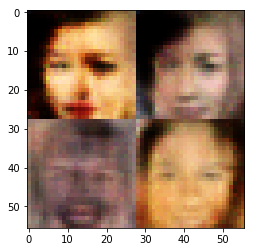

Epoch 1/1... Discriminator Loss: 0.6334... Generator Loss: 2.0647
Epoch 1/1... Discriminator Loss: 0.8687... Generator Loss: 2.1837
Epoch 1/1... Discriminator Loss: 0.5257... Generator Loss: 2.1739
Epoch 1/1... Discriminator Loss: 0.4577... Generator Loss: 3.5774
Epoch 1/1... Discriminator Loss: 0.5407... Generator Loss: 1.9142
Epoch 1/1... Discriminator Loss: 0.5464... Generator Loss: 3.1065
Epoch 1/1... Discriminator Loss: 0.6509... Generator Loss: 6.6646
Epoch 1/1... Discriminator Loss: 1.1485... Generator Loss: 1.6778
Epoch 1/1... Discriminator Loss: 0.7977... Generator Loss: 1.9638
Epoch 1/1... Discriminator Loss: 0.6633... Generator Loss: 1.7776


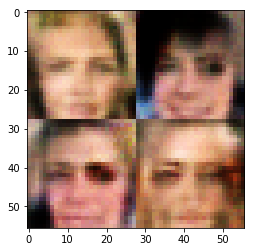

Epoch 1/1... Discriminator Loss: 0.9873... Generator Loss: 1.7043
Epoch 1/1... Discriminator Loss: 0.9456... Generator Loss: 0.9128
Epoch 1/1... Discriminator Loss: 0.9628... Generator Loss: 1.1297
Epoch 1/1... Discriminator Loss: 0.6233... Generator Loss: 2.7305
Epoch 1/1... Discriminator Loss: 0.5589... Generator Loss: 1.8096
Epoch 1/1... Discriminator Loss: 0.4518... Generator Loss: 2.9395
Epoch 1/1... Discriminator Loss: 0.7268... Generator Loss: 1.3199
Epoch 1/1... Discriminator Loss: 2.0466... Generator Loss: 0.3416
Epoch 1/1... Discriminator Loss: 0.8166... Generator Loss: 1.1750
Epoch 1/1... Discriminator Loss: 0.8561... Generator Loss: 4.6452


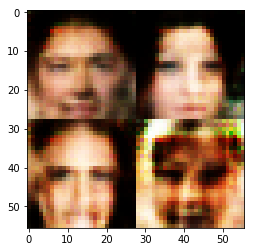

Epoch 1/1... Discriminator Loss: 0.5413... Generator Loss: 1.9718
Epoch 1/1... Discriminator Loss: 0.4134... Generator Loss: 2.8897
Epoch 1/1... Discriminator Loss: 1.1378... Generator Loss: 3.3500
Epoch 1/1... Discriminator Loss: 0.5652... Generator Loss: 2.7859
Epoch 1/1... Discriminator Loss: 0.4410... Generator Loss: 2.6356
Epoch 1/1... Discriminator Loss: 2.8946... Generator Loss: 4.0547
Epoch 1/1... Discriminator Loss: 0.5743... Generator Loss: 2.5821
Epoch 1/1... Discriminator Loss: 0.4502... Generator Loss: 2.9009
Epoch 1/1... Discriminator Loss: 1.5522... Generator Loss: 0.4383
Epoch 1/1... Discriminator Loss: 0.5157... Generator Loss: 2.0323


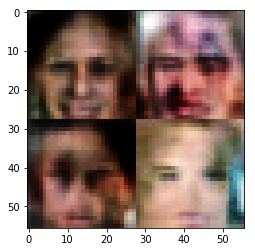

Epoch 1/1... Discriminator Loss: 0.4404... Generator Loss: 2.8581
Epoch 1/1... Discriminator Loss: 0.5511... Generator Loss: 6.2958
Epoch 1/1... Discriminator Loss: 0.4581... Generator Loss: 4.0948
Epoch 1/1... Discriminator Loss: 0.3809... Generator Loss: 3.4948
Epoch 1/1... Discriminator Loss: 0.4410... Generator Loss: 4.6120
Epoch 1/1... Discriminator Loss: 1.0048... Generator Loss: 2.1026
Epoch 1/1... Discriminator Loss: 0.4603... Generator Loss: 2.4265
Epoch 1/1... Discriminator Loss: 0.9487... Generator Loss: 0.8945
Epoch 1/1... Discriminator Loss: 0.3935... Generator Loss: 4.6140
Epoch 1/1... Discriminator Loss: 0.3917... Generator Loss: 3.9237


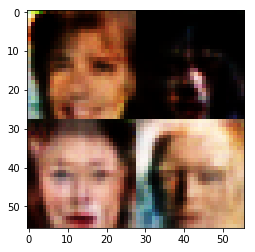

Epoch 1/1... Discriminator Loss: 0.6646... Generator Loss: 1.5123
Epoch 1/1... Discriminator Loss: 0.4808... Generator Loss: 2.6306
Epoch 1/1... Discriminator Loss: 1.0305... Generator Loss: 1.0327
Epoch 1/1... Discriminator Loss: 0.4520... Generator Loss: 2.5607
Epoch 1/1... Discriminator Loss: 0.9402... Generator Loss: 1.0098
Epoch 1/1... Discriminator Loss: 0.9362... Generator Loss: 0.9238
Epoch 1/1... Discriminator Loss: 0.4332... Generator Loss: 4.3462
Epoch 1/1... Discriminator Loss: 0.8199... Generator Loss: 4.6467
Epoch 1/1... Discriminator Loss: 0.4262... Generator Loss: 5.6365
Epoch 1/1... Discriminator Loss: 0.4709... Generator Loss: 4.1675


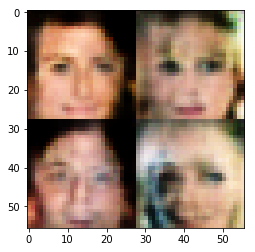

Epoch 1/1... Discriminator Loss: 0.4924... Generator Loss: 2.2315
Epoch 1/1... Discriminator Loss: 0.6168... Generator Loss: 1.6698
Epoch 1/1... Discriminator Loss: 0.3801... Generator Loss: 4.0211
Epoch 1/1... Discriminator Loss: 1.1517... Generator Loss: 2.4425
Epoch 1/1... Discriminator Loss: 0.7905... Generator Loss: 4.9190
Epoch 1/1... Discriminator Loss: 0.7634... Generator Loss: 1.3134
Epoch 1/1... Discriminator Loss: 0.6142... Generator Loss: 1.6031
Epoch 1/1... Discriminator Loss: 0.3795... Generator Loss: 3.6340
Epoch 1/1... Discriminator Loss: 0.4368... Generator Loss: 2.6604
Epoch 1/1... Discriminator Loss: 3.0139... Generator Loss: 0.1668


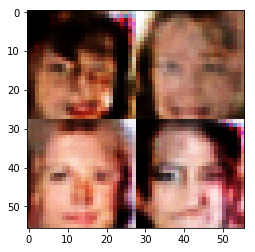

Epoch 1/1... Discriminator Loss: 1.1272... Generator Loss: 1.0127
Epoch 1/1... Discriminator Loss: 0.7358... Generator Loss: 1.4090
Epoch 1/1... Discriminator Loss: 0.5417... Generator Loss: 3.7076
Epoch 1/1... Discriminator Loss: 0.7712... Generator Loss: 2.1111
Epoch 1/1... Discriminator Loss: 0.6600... Generator Loss: 1.6861
Epoch 1/1... Discriminator Loss: 0.7282... Generator Loss: 1.3820
Epoch 1/1... Discriminator Loss: 0.7560... Generator Loss: 1.2693
Epoch 1/1... Discriminator Loss: 0.5731... Generator Loss: 2.6720
Epoch 1/1... Discriminator Loss: 0.8033... Generator Loss: 4.0524
Epoch 1/1... Discriminator Loss: 0.3842... Generator Loss: 6.7024


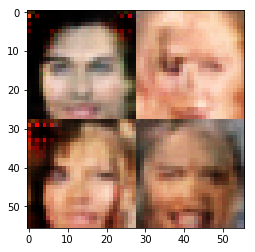

Epoch 1/1... Discriminator Loss: 0.8123... Generator Loss: 1.2983
Epoch 1/1... Discriminator Loss: 0.8235... Generator Loss: 3.4347
Epoch 1/1... Discriminator Loss: 0.3900... Generator Loss: 4.4977
Epoch 1/1... Discriminator Loss: 0.5808... Generator Loss: 1.8752
Epoch 1/1... Discriminator Loss: 1.3475... Generator Loss: 1.7225
Epoch 1/1... Discriminator Loss: 1.0048... Generator Loss: 2.7524
Epoch 1/1... Discriminator Loss: 0.6329... Generator Loss: 1.6922
Epoch 1/1... Discriminator Loss: 2.6663... Generator Loss: 4.0082
Epoch 1/1... Discriminator Loss: 0.9391... Generator Loss: 0.9868
Epoch 1/1... Discriminator Loss: 0.6209... Generator Loss: 1.8276


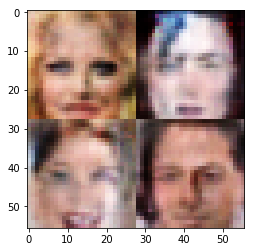

Epoch 1/1... Discriminator Loss: 0.7091... Generator Loss: 2.8161
Epoch 1/1... Discriminator Loss: 0.3925... Generator Loss: 3.8928
Epoch 1/1... Discriminator Loss: 0.4428... Generator Loss: 3.2830
Epoch 1/1... Discriminator Loss: 0.3668... Generator Loss: 4.2227
Epoch 1/1... Discriminator Loss: 0.3613... Generator Loss: 4.6081
Epoch 1/1... Discriminator Loss: 0.3476... Generator Loss: 6.5188
Epoch 1/1... Discriminator Loss: 0.3849... Generator Loss: 3.8528
Epoch 1/1... Discriminator Loss: 0.4492... Generator Loss: 2.7534
Epoch 1/1... Discriminator Loss: 0.9172... Generator Loss: 5.1334
Epoch 1/1... Discriminator Loss: 0.5835... Generator Loss: 2.0403


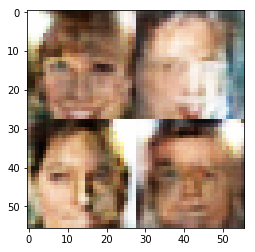

Epoch 1/1... Discriminator Loss: 0.3578... Generator Loss: 5.0305
Epoch 1/1... Discriminator Loss: 0.3805... Generator Loss: 3.5869
Epoch 1/1... Discriminator Loss: 0.3855... Generator Loss: 4.6491
Epoch 1/1... Discriminator Loss: 0.4013... Generator Loss: 3.1715
Epoch 1/1... Discriminator Loss: 0.4002... Generator Loss: 3.0813
Epoch 1/1... Discriminator Loss: 0.5033... Generator Loss: 2.1833
Epoch 1/1... Discriminator Loss: 0.6588... Generator Loss: 1.5058
Epoch 1/1... Discriminator Loss: 0.4293... Generator Loss: 3.2602
Epoch 1/1... Discriminator Loss: 0.3686... Generator Loss: 3.8760
Epoch 1/1... Discriminator Loss: 0.4815... Generator Loss: 2.3400


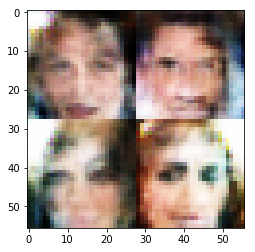

Epoch 1/1... Discriminator Loss: 0.3749... Generator Loss: 4.2940
Epoch 1/1... Discriminator Loss: 0.4647... Generator Loss: 2.3394
Epoch 1/1... Discriminator Loss: 0.3864... Generator Loss: 3.7964
Epoch 1/1... Discriminator Loss: 0.3727... Generator Loss: 4.0388
Epoch 1/1... Discriminator Loss: 0.3790... Generator Loss: 3.5949
Epoch 1/1... Discriminator Loss: 0.7522... Generator Loss: 2.1511
Epoch 1/1... Discriminator Loss: 0.4829... Generator Loss: 2.5182
Epoch 1/1... Discriminator Loss: 0.4907... Generator Loss: 2.4540
Epoch 1/1... Discriminator Loss: 0.4554... Generator Loss: 3.1298
Epoch 1/1... Discriminator Loss: 0.4923... Generator Loss: 2.3465


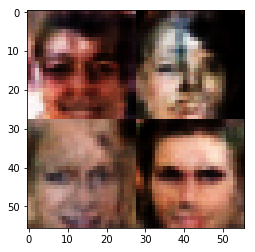

Epoch 1/1... Discriminator Loss: 0.8300... Generator Loss: 1.1653
Epoch 1/1... Discriminator Loss: 0.7486... Generator Loss: 1.3447
Epoch 1/1... Discriminator Loss: 0.8467... Generator Loss: 1.4037
Epoch 1/1... Discriminator Loss: 1.0117... Generator Loss: 0.9190
Epoch 1/1... Discriminator Loss: 1.4524... Generator Loss: 0.5211
Epoch 1/1... Discriminator Loss: 0.8500... Generator Loss: 1.7693
Epoch 1/1... Discriminator Loss: 0.7809... Generator Loss: 2.3591
Epoch 1/1... Discriminator Loss: 0.5820... Generator Loss: 2.1188
Epoch 1/1... Discriminator Loss: 0.7453... Generator Loss: 2.1603
Epoch 1/1... Discriminator Loss: 0.9026... Generator Loss: 3.6035


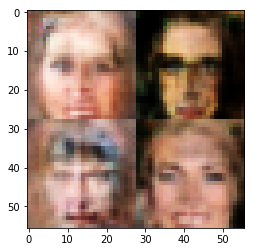

Epoch 1/1... Discriminator Loss: 0.7167... Generator Loss: 1.5159
Epoch 1/1... Discriminator Loss: 0.5293... Generator Loss: 2.0272
Epoch 1/1... Discriminator Loss: 2.6022... Generator Loss: 0.1668
Epoch 1/1... Discriminator Loss: 0.5742... Generator Loss: 2.7259
Epoch 1/1... Discriminator Loss: 0.7371... Generator Loss: 2.9163
Epoch 1/1... Discriminator Loss: 1.1092... Generator Loss: 2.6175
Epoch 1/1... Discriminator Loss: 0.6559... Generator Loss: 1.6417
Epoch 1/1... Discriminator Loss: 0.5564... Generator Loss: 2.6086
Epoch 1/1... Discriminator Loss: 0.9502... Generator Loss: 0.8815
Epoch 1/1... Discriminator Loss: 0.6371... Generator Loss: 1.5812


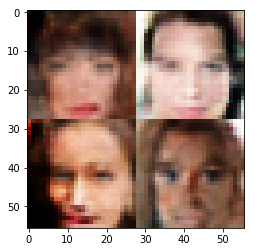

Epoch 1/1... Discriminator Loss: 1.7896... Generator Loss: 0.3785
Epoch 1/1... Discriminator Loss: 1.2081... Generator Loss: 0.6338
Epoch 1/1... Discriminator Loss: 1.8621... Generator Loss: 0.3392
Epoch 1/1... Discriminator Loss: 0.4653... Generator Loss: 2.7244
Epoch 1/1... Discriminator Loss: 0.6621... Generator Loss: 1.4989
Epoch 1/1... Discriminator Loss: 0.7630... Generator Loss: 1.3898
Epoch 1/1... Discriminator Loss: 0.5384... Generator Loss: 2.1300
Epoch 1/1... Discriminator Loss: 0.4579... Generator Loss: 2.6091
Epoch 1/1... Discriminator Loss: 0.4427... Generator Loss: 2.7663
Epoch 1/1... Discriminator Loss: 2.1747... Generator Loss: 2.7861


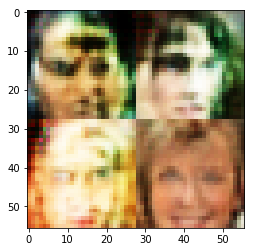

Epoch 1/1... Discriminator Loss: 1.2561... Generator Loss: 0.9815
Epoch 1/1... Discriminator Loss: 1.1959... Generator Loss: 1.0461


In [13]:
batch_size = 100
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.